# PS7 - Arath Reyes

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
from scipy.stats import t
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_arch
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = r'/Users/arathreyes/Documents/Repos/Personal/Data/Data_PG_UN.csv'
data = pd.read_csv(path)
data['Date'] =  data['Date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').date())
data.set_index('Date', inplace = True)
data.head()

,PG,UN,HH,MKT,RF
Date,,,,,
1994-01-31,0.008772,0.004329,0.0247,0.0312,0.0025
1994-02-28,0.016397,0.020473,-0.0121,-0.0235,0.0021
1994-03-31,-0.019355,-0.061245,-0.0504,-0.0451,0.0027
1994-04-30,-0.078947,-0.087739,0.0164,0.0095,0.0027
1994-05-31,0.082419,0.092478,0.0092,0.0089,0.0031


## 0. Exploratory Analysis

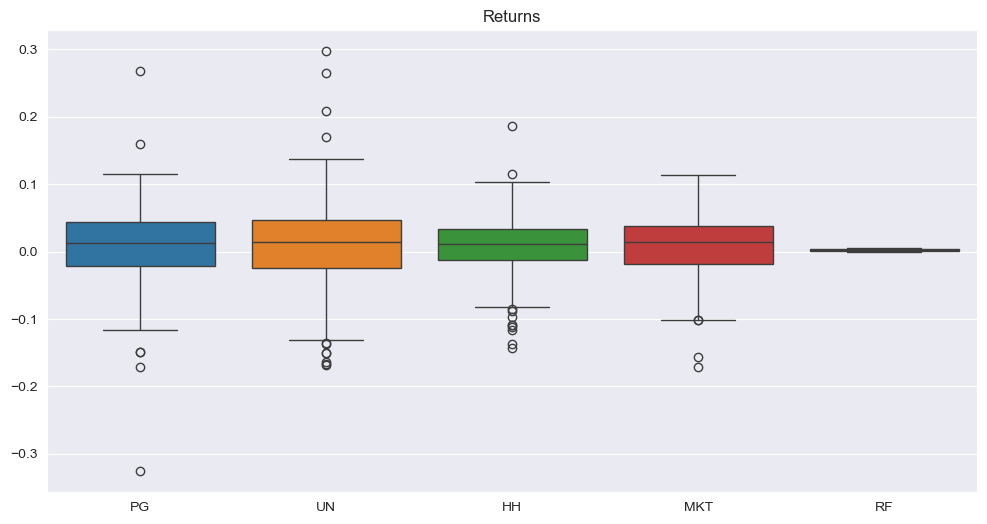

In [5]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data)
ax.set_title(f'Returns')
plt.show()

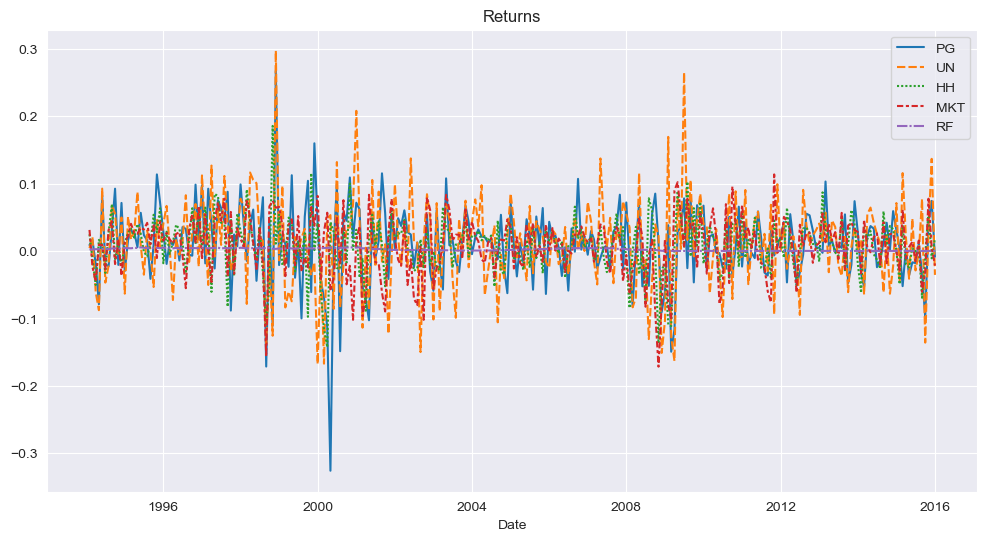

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data)
ax.set_title(f'Returns')
plt.show()

Notice that there are some outliers in $PG$, $UN$ and $HH$. In a more in-depth analysis we should look through those outliers and identify what might be the cause of them - data errors, idiosyncratic factors (e.g. quarter financial reports) or exogenous events (e.g. a market crash). And either keep them in the analysis or to remove them/smooth them out afterwards

On top of that, we can see that there are some volatility clusters around the years 1997 and 2008 - Which are expected as per the Asian Financial Crisis and the Housing Financial crisis, respectively.

In [8]:
class OLS:

    def __init__(self, y, X):
        self.y = y
        self.X = sm.add_constant(X).values
        self.y_pred = np.nan
        self.coeﬀicients = {}
        self.residuals = np.nan
        self.r_squared = np.nan
        self.adj_r_squared = np.nan
        self.covariance_matrix = np.nan
        self.standard_errors = np.nan
        self.t_test = pd.DataFrame()
        self.confidence_intervals = pd.DataFrame()
        self.white_covariance_matrix = np.nan
        self.white_confidence_intervals = pd.DataFrame()
        self.white_t_test = pd.DataFrame()
        self.AIC = np.nan
        self.BIC = np.nan
        self.HQIC = np.nan
        self.autocorrelation_test = pd.DataFrame()
        self.normality_tests = pd.DataFrame()
        self.arch_test = pd.DataFrame()
        self.VIF = pd.DataFrame()
        
        self.fitted = False
    
    def fit(self):
        
        beta = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
        # Compute fitted values and residuals
        self.y_pred = self.X @ beta
        self.residuals = self.y - self.y_pred
        
        # Calculate R-squared and adjusted R-squared
        SST = np.sum((self.y - np.mean(self.y))**2)
        SSR = np.sum((self.y_pred - np.mean(self.y))**2)
        SSE = np.sum(self.residuals**2)

        self.r_squared = SSR / SST
        self.adj_r_squared = 1 - (1 - self.r_squared) * (len(self.y) - 1) / (len(self.y) - self.X.shape[1])
        self.coefficients = pd.DataFrame.from_dict({'Alpha' if i == 0 else f'Beta {i}': [b] for i,b in enumerate(beta)})
        idx = ['Alpha'] + [f'Beta {i+1}' for i in range(len(beta) -1)]
        # Covariance Matrix
        sigma_squared = SSE / (len(self.y) - self.X.shape[1])  # Variance of residuals
        self.covariance_matrix = sigma_squared * np.linalg.inv(self.X.T @ self.X)

        # Standard errors of the coefficients (square root of diagonal elements of var-covar matrix)
        self.standard_errors = np.sqrt(np.diag(self.covariance_matrix))
        
        #  t-test
        t_stats = beta / self.standard_errors
        dof = len(self.y) - self.X.shape[1]
        p_values = [2 * (1 - t.cdf(abs(t_stat), dof)) for t_stat in t_stats]
        self.t_test = pd.DataFrame({
            'Coefficient': idx,
            'Estimate': beta,
            'Std. Error': self.standard_errors,
            't-Statistic': t_stats,
            'p-Value': p_values
        })

        # Confidence intervals under homoskedasticity
        confidence_levels = [0.90, 0.95, 0.99]
        z_values = [t.ppf(1 - (1 - cl) / 2, dof) for cl in confidence_levels]
        
        # Compute confidence intervals for each coefficient
        conf_interval = {
            f"{int(cl * 100)}%": [
                (round(beta[i] - z * self.standard_errors[i], 4), round(beta[i] + z * self.standard_errors[i], 4)) 
                for i in range(len(beta))
            ] 
            for cl, z in zip(confidence_levels, z_values)
        }
        self.confidence_intervals = pd.DataFrame(conf_interval, index= idx)

        # White's heteroskedasticity-consistent variance-covariance matrix
        residuals_squared = self.residuals**2
        X_squared = self.X.T @ np.diag(residuals_squared) @ self.X
        self.white_covariance_matrix = np.linalg.inv(self.X.T @ self.X) @ X_squared @ np.linalg.inv(self.X.T @ self.X)
        
        # Compute standard errors from White's variance-covariance matrix
        white_standard_errors = np.sqrt(np.diag(self.white_covariance_matrix))
        conf_intervals_white = {
            f"{int(cl * 100)}% CI": [
                (round(beta[i] - z * white_standard_errors[i],4), round(beta[i] + z * white_standard_errors[i],4)) 
                for i in range(len(beta))
            ] 
            for cl, z in zip(confidence_levels, z_values)
        }

        self.white_confidence_intervals = pd.DataFrame(conf_intervals_white, index=idx)

        # t-test under heteroskedasticity
        white_t_stats = beta / white_standard_errors
        white_p_values = [2 * (1 - t.cdf(abs(t_stat), dof)) for t_stat in white_t_stats]
        
        # T-test results under heteroskedasticity
        self.white_t_test = pd.DataFrame({
            'Coefficient': idx,
            'Estimate': beta,
            'Std. Error': white_standard_errors,
            't-Statistic': white_t_stats,
            'p-Value': white_p_values
        })
        
        # AIC, BIC, and Hannah-Quinn Information Criteria
        n = len(self.y)
        k = self.X.shape[1]
        self.AIC = n * np.log(SSE / n) + 2 * k + n*(1 + np.log(2*np.pi))
        self.BIC = n * np.log(SSE / n) + k * np.log(n) + n*(1 + np.log(2*np.pi))
        self.HQIC = n * np.log(SSE / n) + 2 * k * np.log(np.log(n)) + n*(1 + np.log(2*np.pi))
        
        # Durbin-Watson test
        dw_stat = np.sum(np.diff(self.residuals)**2) / np.sum(self.residuals**2)
        
        # Breusch-Godfrey test
        residuals_lag = self.residuals[:-1]
        residuals_current = self.residuals[1:]
        bg_X = np.vstack([np.ones(len(residuals_lag)), residuals_lag]).T
        bg_beta = np.linalg.inv(bg_X.T @ bg_X) @ bg_X.T @ residuals_current
        bg_pred = bg_X @ bg_beta
        bg_residuals = residuals_current - bg_pred
        bg_R2 = 1 - np.sum(bg_residuals**2) / np.sum((residuals_current - np.mean(residuals_current))**2)
        bg_stat = len(residuals_lag) * bg_R2
        
        self.autocorrelation_test = pd.DataFrame({
            'Test': ['Durbin-Watson', 'Breusch-Godfrey'],
            'Statistic': [dw_stat, bg_stat]
        })

        # Normality tests
        shapiro_test_stat, shapiro_p_value = stats.shapiro(self.residuals)
        jb_test_stat, jb_p_value, = stats.jarque_bera(self.residuals)
        
        # Compile normality test results
        self.normality_tests = pd.DataFrame({
            'Test': ['Shapiro-Wilk', 'Jarque-Bera'],
            'Statistic': [shapiro_test_stat, jb_test_stat],
            'p-Value': [shapiro_p_value, jb_p_value]
        })

        # ARCH test on residuals
        arch_test_stat, arch_test_p_value, _, _ = het_arch(self.residuals)
        
        # Compile and display results of the ARCH test
        self.arch_test = pd.DataFrame({
            'Test Statistic': [arch_test_stat],
            'p-Value': [arch_test_p_value]
        }, index=['ARCH Test'])
        
        # Test multicolinearuty
        self.VIF = pd.DataFrame({
            'Variable': idx,
            'VIF': [variance_inflation_factor(self.X, i) for i in range(self.X.shape[1])]
        })

        # Format some outputs
        self.covariance_matrix = pd.DataFrame(self.covariance_matrix, index = idx, columns = idx)
        self.white_covariance_matrix = pd.DataFrame(self.white_covariance_matrix, index = idx, columns = idx)

        self.fitted = True
        return

    def plot_residuals(self):
        if not self.fitted:
            raise Exception('OLS not fitted yet')
        sns.set_style('darkgrid')
        sm.qqplot(self.residuals, line='s')
        plt.title('Q-Q Plot of Residuals')
        plt.show()

        sns.set_style('darkgrid')
        plt.figure(figsize=(12, 6))
        sns.lineplot(self.residuals)
        plt.xlabel('Date')
        plt.ylabel('Residuals')
        plt.title(f'Residuals')
        plt.show()

        sns.set_style('darkgrid')
        plt.figure(figsize=(7.5, 7.5))
        sns.scatterplot(x = self.residuals[:-1].values, y = self.residuals[1:].values)
        plt.xlabel('T-1')
        plt.ylabel('T')
        plt.title(f'Residuals')
        plt.show()

        plt.figure(figsize=(10, 5))
        sm.graphics.tsa.plot_acf(self.residuals, lags=15, alpha=0.05)
        plt.title("Autocorrelation Plot of Residuals")
        plt.show()
    
    def plot_rolling_betas(self, rolling_window = 60):
        
        rolling_betas = []
        rolling_conf_intervals = []
        
        for start in range(len(self.X) - rolling_window + 1):
            window_y = self.y[start:start + rolling_window]
            window_X = self.X[start:start + rolling_window]
            
            # Estimate coefficients for the current window
            beta_window = np.linalg.inv(window_X.T @ window_X) @ window_X.T @ window_y
            residuals_window = window_y - window_X @ beta_window
            
            sigma_squared_window = np.sum(residuals_window**2) / (rolling_window - window_X.shape[1])
            var_covar_matrix_window = sigma_squared_window * np.linalg.inv(window_X.T @ window_X)
            standard_errors_window = np.sqrt(np.diag(var_covar_matrix_window))
            
            rolling_betas.append(beta_window[1:])
            rolling_conf_intervals.append([
                beta_window[1:] - 1.96 * standard_errors_window[1:],  
                beta_window[1:] + 1.96 * standard_errors_window[1:]  
            ])
        
        rolling_betas = np.array(rolling_betas)
        rolling_conf_intervals = np.array(rolling_conf_intervals)
        dates = self.y.index[-len(rolling_betas):]
        # Plot rolling beta coefficients with confidence intervals
        sns.set_style('darkgrid')
        plt.figure(figsize=(12, 6))
        for i in range(self.X.shape[1]-1):
            plt.plot(dates, rolling_betas[:, i], label=f'Beta {i+1}')
            plt.fill_between(dates,
                             rolling_conf_intervals[:, 0, i],
                             rolling_conf_intervals[:, 1, i],
                             alpha=0.2, label= f'95% CI Beta {i+1}')
            
        plt.xlabel('Date')
        plt.ylabel('Beta')
        plt.title(f'Rolling Betas - {rolling_window} Months Window')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return

## 1. UN vs MKT

In [10]:
y = data.UN - data.RF
X = data.MKT - data.RF

In [11]:
ols = OLS(y,X)
ols.fit()

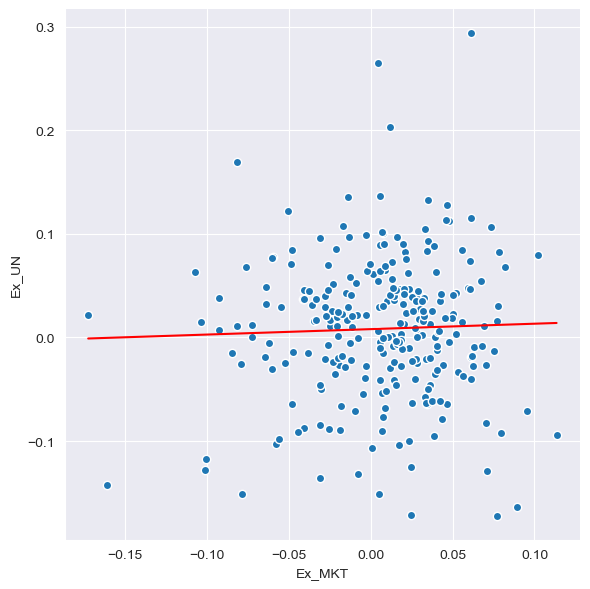

In [12]:
alpha, beta = ols.coefficients.values.tolist()[0]
f = lambda x: alpha + beta*x
x = np.linspace(min(X), max(X), 1_000)
scat_plot = pd.DataFrame()
scat_plot['Ex_MKT'] = X
scat_plot['Ex_UN'] = y
g = sns.FacetGrid(scat_plot, height = 6)
g = g.map(plt.scatter, "Ex_MKT", "Ex_UN", edgecolor="w")
plt.plot(x, f(x), color='r')
plt.show()

In [13]:
print(f'\n\
====================== Coefficients ======================\n\
{ols.coefficients.to_string(index = False, justify ="center")}\n\n\
======================= Performance =======================\n\
R-Squared: {round(ols.r_squared,4)} | Adjusted R-Squared: {round(ols.adj_r_squared,4)}\n\
AIC: {round(ols.AIC,3)} | BIC: {round(ols.BIC,3)} | HQIC: {round(ols.HQIC,3)}\n\n\
================== Confidence Intervals ==================\n\
{ols.confidence_intervals.to_string(justify ="center")}\n\n\
========================= t-Test =========================\n\
{ols.t_test.to_string(index = False, justify ="center")}\n\n\
==================== Covariance Matrix ====================\n\
{ols.covariance_matrix.to_string(justify ="center")}\n\n\
================== Autocorrelation Test ==================\n\
{ols.autocorrelation_test.to_string(index = False, justify ="center")}\n\n\
===================== Normality Test =====================\n\
{ols.normality_tests.to_string(index = False, justify ="center")}\n\n\
======================== ARCH Test ========================\n\
{ols.arch_test.to_string(justify ="center")}\n\n\
==================== Multicollinearity ====================\n\
{ols.VIF.to_string(index = False, justify ="center")}\n\n\
================ White Confidence Intervals ================\n\
{ols.white_confidence_intervals.to_string(justify ="center")}\n\n\
======================= White t-Test =======================\n\
{ols.white_t_test.to_string(index = False, justify ="center")}\n\n\
================== White Covariance Matrix ==================\n\
{ols.white_covariance_matrix.to_string(justify ="center")}\n\n\
')


====================== Coefficients ======================
  Alpha   Beta 1
0.008043 0.05243

======================= Performance =======================
R-Squared: 0.0012 | Adjusted R-Squared: -0.0026
AIC: -671.661 | BIC: -664.509 | HQIC: -668.787

================== Confidence Intervals ==================
              90%                95%                99%        
Alpha     (0.0011, 0.015)  (-0.0002, 0.0163)  (-0.0028, 0.0189)
Beta 1  (-0.1033, 0.2081)  (-0.1333, 0.2382)  (-0.1923, 0.2972)

========================= t-Test =========================
Coefficient  Estimate  Std. Error  t-Statistic  p-Value
    Alpha    0.008043   0.004197    1.916357   0.056408
   Beta 1    0.052430   0.094335    0.555780   0.578836

==================== Covariance Matrix ====================
          Alpha    Beta 1 
Alpha   0.000018 -0.000054
Beta 1 -0.000054  0.008899

================== Autocorrelation Test ==================
      Test       Statistic
  Durbin-Watson  2.313946 
Breusch-Godfre

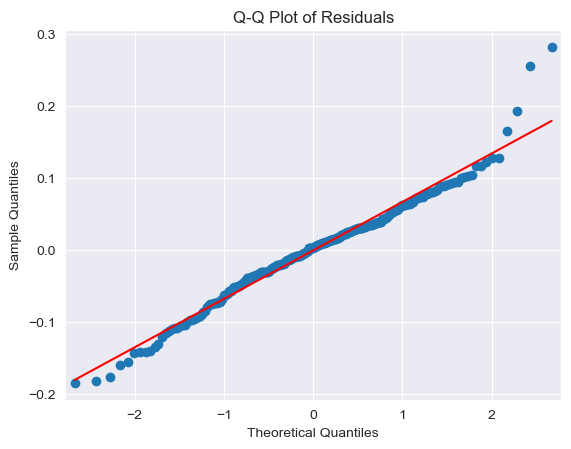

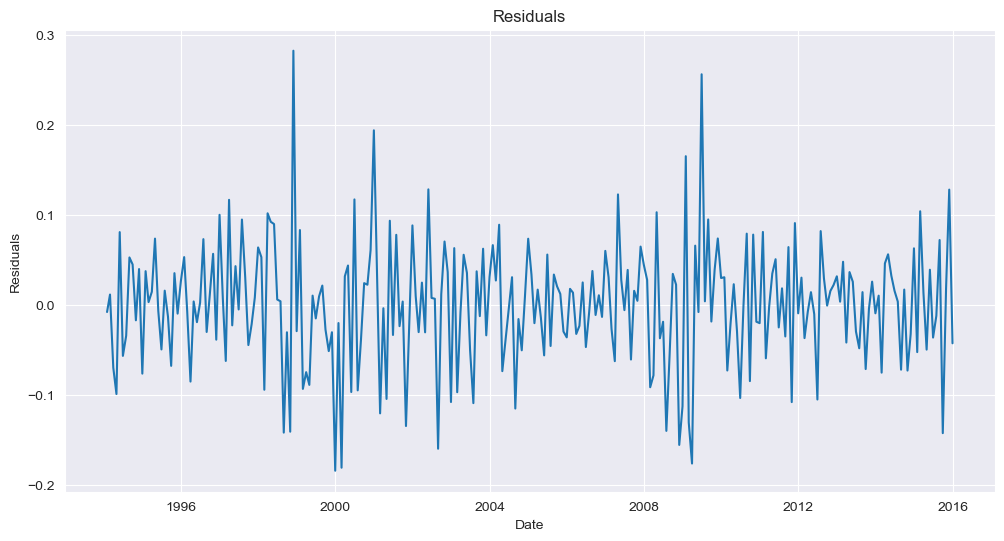

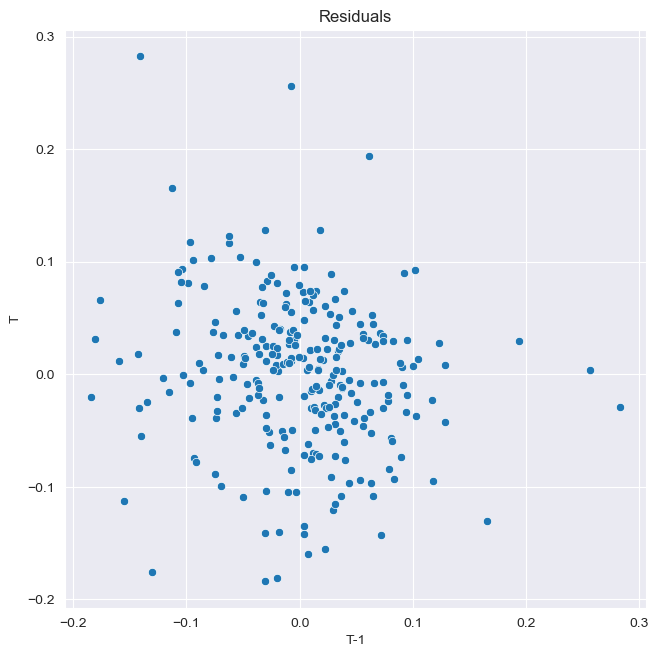

<Figure size 1000x500 with 0 Axes>

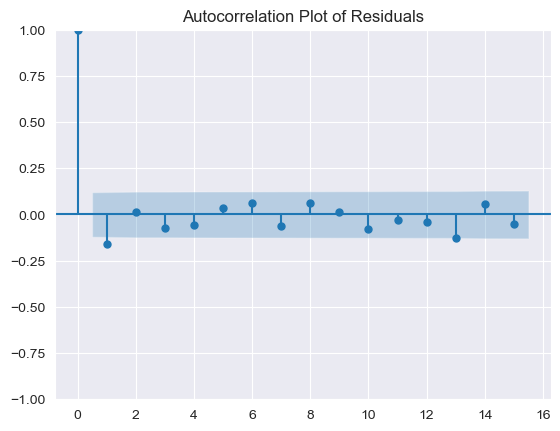

In [14]:
ols.plot_residuals()

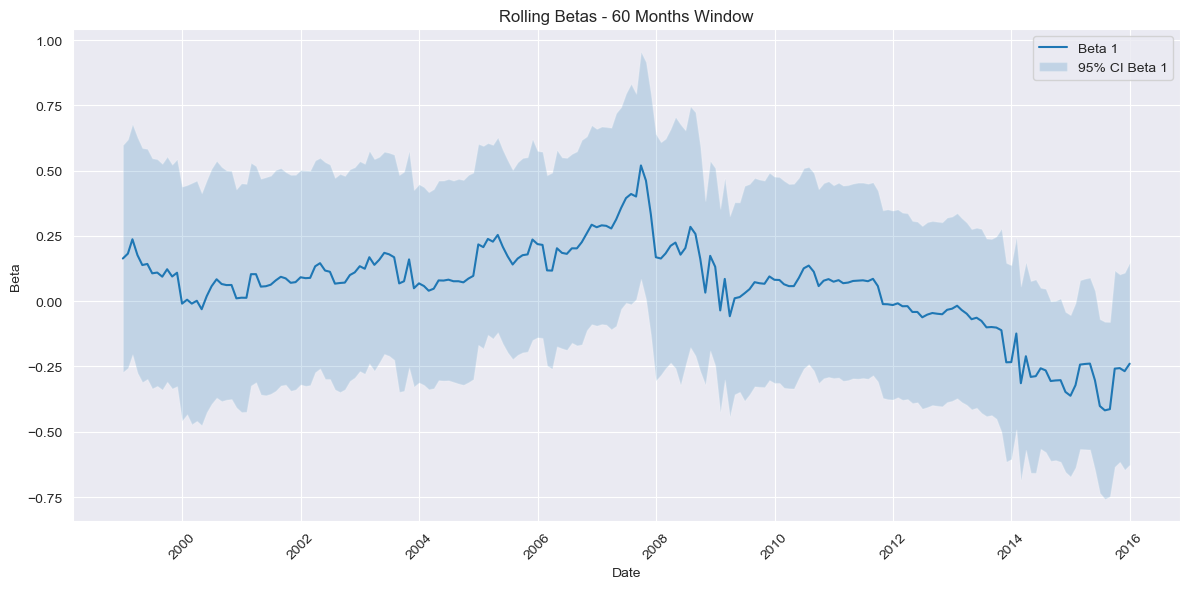

In [15]:
ols.plot_rolling_betas()

In [16]:
model = sm.OLS(y, sm.add_constant(X)).fit()
#model.cov_params()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3089
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.579
Time:                        14:51:47   Log-Likelihood:                 337.83
No. Observations:                 264   AIC:                            -671.7
Df Residuals:                     262   BIC:                            -664.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.004      1.916      0.0

## 2. UN vs MKT + HH

In [18]:
y = data.UN - data.RF
X2 = data[['MKT', 'HH']]
X2.MKT -= data.RF
X2.HH -= data.RF

/var/folders/0t/9frdxs_x6xx6_qtzmnr8p5c40000gn/T/ipykernel_19165/3537745714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2.MKT -= data.RF
/var/folders/0t/9frdxs_x6xx6_qtzmnr8p5c40000gn/T/ipykernel_19165/3537745714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2.HH -= data.RF


In [19]:
ols2 = OLS(y,X2)
ols2.fit()

In [20]:
print(f'\n\
====================== Coefficients ======================\n\
{ols2.coefficients.to_string(index = False, justify ="center")}\n\n\
======================= Performance =======================\n\
R-Squared: {round(ols2.r_squared,4)} | Adjusted R-Squared: {round(ols2.adj_r_squared,4)}\n\
AIC: {round(ols2.AIC,3)} | BIC: {round(ols2.BIC,3)} | HQIC: {round(ols2.HQIC,3)}\n\n\
================== Confidence Intervals ==================\n\
{ols2.confidence_intervals.to_string(justify ="center")}\n\n\
========================= t-Test =========================\n\
{ols2.t_test.to_string(index = False, justify ="center")}\n\n\
==================== Covariance Matrix ====================\n\
{ols2.covariance_matrix.to_string(justify ="center")}\n\n\
================== Autocorrelation Test ==================\n\
{ols2.autocorrelation_test.to_string(index = False, justify ="center")}\n\n\
===================== Normality Test =====================\n\
{ols2.normality_tests.to_string(index = False, justify ="center")}\n\n\
======================== ARCH Test ========================\n\
{ols2.arch_test.to_string(justify ="center")}\n\n\
==================== Multicollinearity ====================\n\
{ols2.VIF.to_string(index = False, justify ="center")}\n\n\
================ White Confidence Intervals ================\n\
{ols2.white_confidence_intervals.to_string(justify ="center")}\n\n\
======================= White t-Test =======================\n\
{ols2.white_t_test.to_string(index = False, justify ="center")}\n\n\
================== White Covariance Matrix ==================\n\
{ols2.white_covariance_matrix.to_string(justify ="center")}\n\n\
')


====================== Coefficients ======================
  Alpha   Beta 1    Beta 2 
0.008244 0.096757 -0.074865

======================= Performance =======================
R-Squared: 0.0025 | Adjusted R-Squared: -0.0051
AIC: -670.015 | BIC: -659.288 | HQIC: -665.705

================== Confidence Intervals ==================
              90%                95%                99%        
Alpha    (0.0013, 0.0152)  (-0.0001, 0.0165)  (-0.0027, 0.0192)
Beta 1  (-0.1022, 0.2957)  (-0.1406, 0.3341)   (-0.216, 0.4095)
Beta 2  (-0.2836, 0.1339)  (-0.3239, 0.1742)   (-0.403, 0.2533)

========================= t-Test =========================
Coefficient  Estimate  Std. Error  t-Statistic  p-Value
    Alpha    0.008244   0.004216    1.955277   0.051618
   Beta 1    0.096757   0.120535    0.802726   0.422863
   Beta 2   -0.074865   0.126472   -0.591951   0.554396

==================== Covariance Matrix ====================
          Alpha    Beta 1    Beta 2 
Alpha   0.000018 -0.000029 -0.

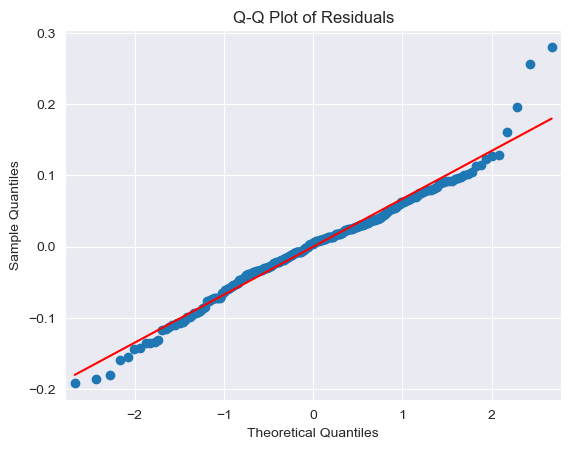

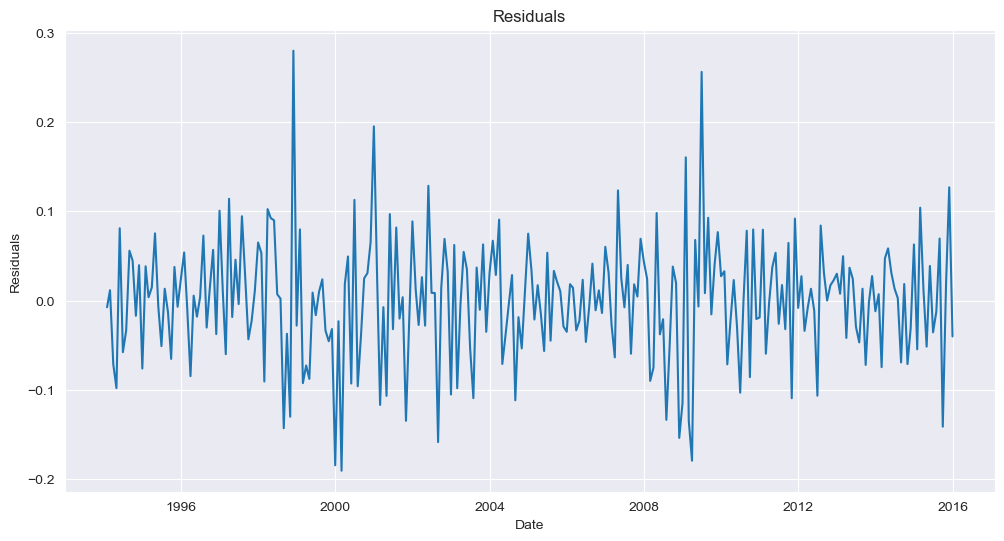

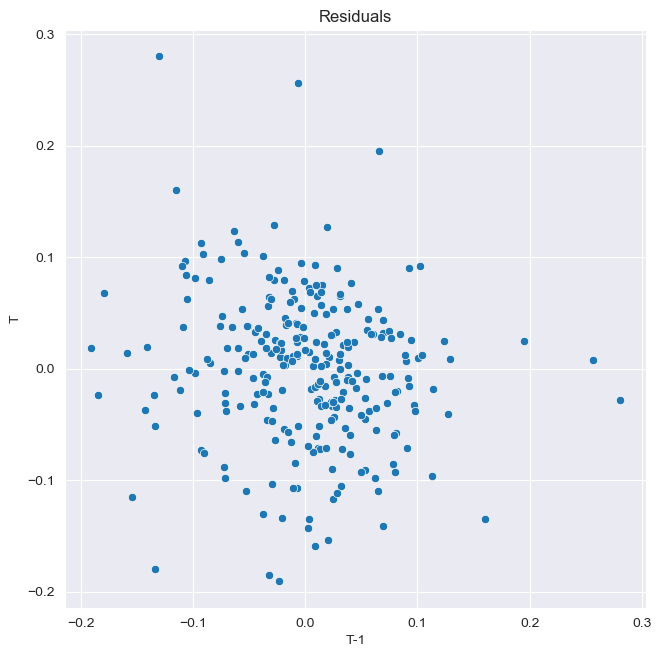

<Figure size 1000x500 with 0 Axes>

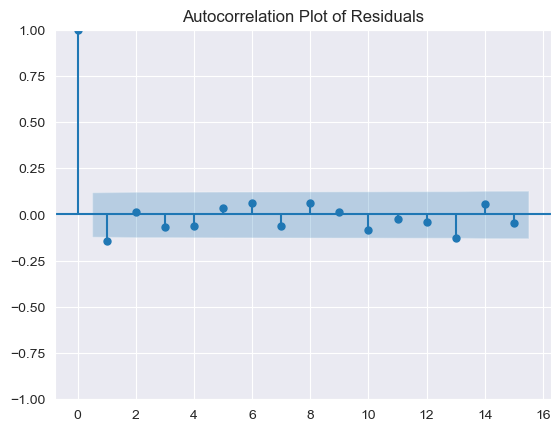

In [21]:
ols2.plot_residuals()

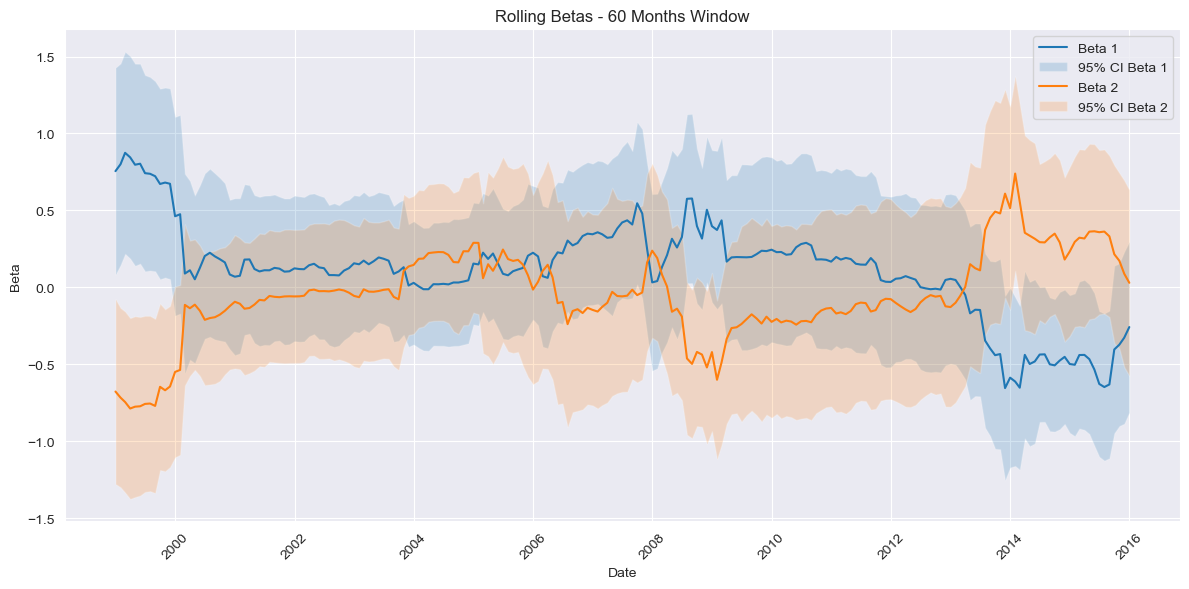

In [22]:
ols2.plot_rolling_betas()

In [23]:
model2 = sm.OLS(y, sm.add_constant(X2)).fit()
#model.cov_params()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3293
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.720
Time:                        14:51:48   Log-Likelihood:                 338.01
No. Observations:                 264   AIC:                            -670.0
Df Residuals:                     261   BIC:                            -659.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.004      1.955      0.0

## 3. Comparing Models

### UN vs HH

In [25]:
y = data.UN - data.RF
X_HH = data.HH - data.RF

In [26]:
ols_HH = OLS(y,X_HH)
ols_HH.fit()

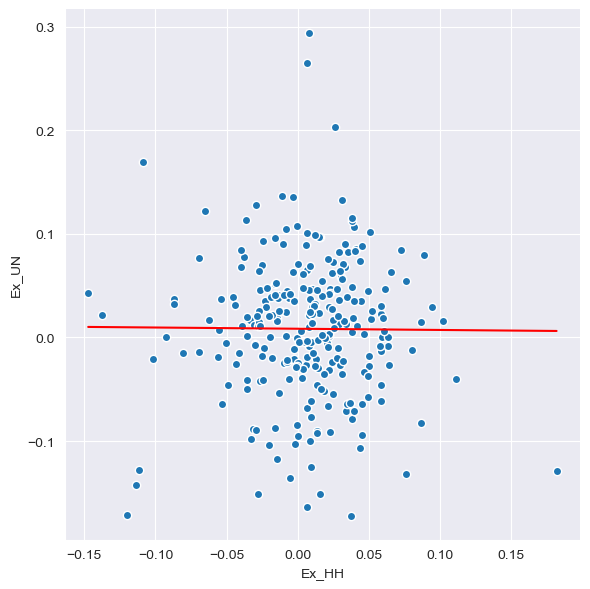

In [27]:
alpha, beta = ols_HH.coefficients.values.tolist()[0]
f = lambda x: alpha + beta*x
x = np.linspace(min(X_HH), max(X_HH), 1_000)
scat_plot = pd.DataFrame()
scat_plot['Ex_HH'] = X_HH
scat_plot['Ex_UN'] = y
g = sns.FacetGrid(scat_plot, height = 6)
g = g.map(plt.scatter, "Ex_HH", "Ex_UN", edgecolor="w")
plt.plot(x, f(x), color='r')
plt.show()

In [28]:
print(f'\n\
====================== Coefficients ======================\n\
{ols_HH.coefficients.to_string(index = False, justify ="center")}\n\n\
======================= Performance =======================\n\
R-Squared: {round(ols_HH.r_squared,4)} | Adjusted R-Squared: {round(ols_HH.adj_r_squared,4)}\n\
AIC: {round(ols_HH.AIC,3)} | BIC: {round(ols_HH.BIC,3)} | HQIC: {round(ols_HH.HQIC,3)}\n\n\
================== Confidence Intervals ==================\n\
{ols_HH.confidence_intervals.to_string(justify ="center")}\n\n\
========================= t-Test =========================\n\
{ols_HH.t_test.to_string(index = False, justify ="center")}\n\n\
==================== Covariance Matrix ====================\n\
{ols_HH.covariance_matrix.to_string(justify ="center")}\n\n\
================== Autocorrelation Test ==================\n\
{ols_HH.autocorrelation_test.to_string(index = False, justify ="center")}\n\n\
===================== Normality Test =====================\n\
{ols_HH.normality_tests.to_string(index = False, justify ="center")}\n\n\
==================== Multicollinearity ====================\n\
{ols_HH.VIF.to_string(index = False, justify ="center")}\n\n\
================ White Confidence Intervals ================\n\
{ols_HH.white_confidence_intervals.to_string(justify ="center")}\n\n\
======================= White t-Test =======================\n\
{ols_HH.white_t_test.to_string(index = False, justify ="center")}\n\n\
================== White Covariance Matrix ==================\n\
{ols_HH.white_covariance_matrix.to_string(justify ="center")}\n\n\
')


====================== Coefficients ======================
  Alpha    Beta 1 
0.008437 -0.011794

======================= Performance =======================
R-Squared: 0.0001 | Adjusted R-Squared: -0.0038
AIC: -671.364 | BIC: -664.213 | HQIC: -668.491

================== Confidence Intervals ==================
              90%                95%                99%        
Alpha    (0.0015, 0.0154)   (0.0002, 0.0167)  (-0.0025, 0.0194)
Beta 1  (-0.1753, 0.1517)  (-0.2068, 0.1832)  (-0.2688, 0.2452)

========================= t-Test =========================
Coefficient  Estimate  Std. Error  t-Statistic  p-Value
    Alpha    0.008437   0.004206    2.005725   0.045914
   Beta 1   -0.011794   0.099037   -0.119084   0.905300

==================== Covariance Matrix ====================
          Alpha    Beta 1 
Alpha   0.000018 -0.000062
Beta 1 -0.000062  0.009808

================== Autocorrelation Test ==================
      Test       Statistic
  Durbin-Watson  2.284882 
Breusch-Go

In [29]:
model_HH = sm.OLS(y, sm.add_constant(X_HH)).fit()
#model.cov_params()
print(model_HH.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.01418
Date:                Sun, 09 Feb 2025   Prob (F-statistic):              0.905
Time:                        14:51:48   Log-Likelihood:                 337.68
No. Observations:                 264   AIC:                            -671.4
Df Residuals:                     262   BIC:                            -664.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.004      2.006      0.0

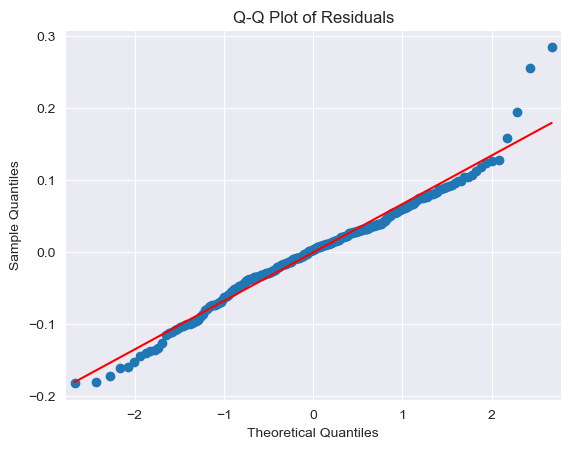

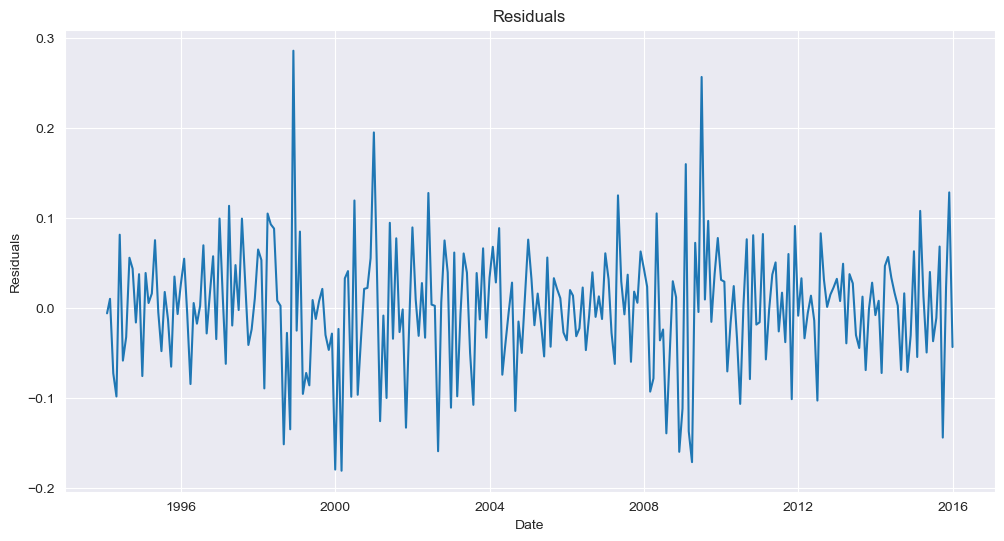

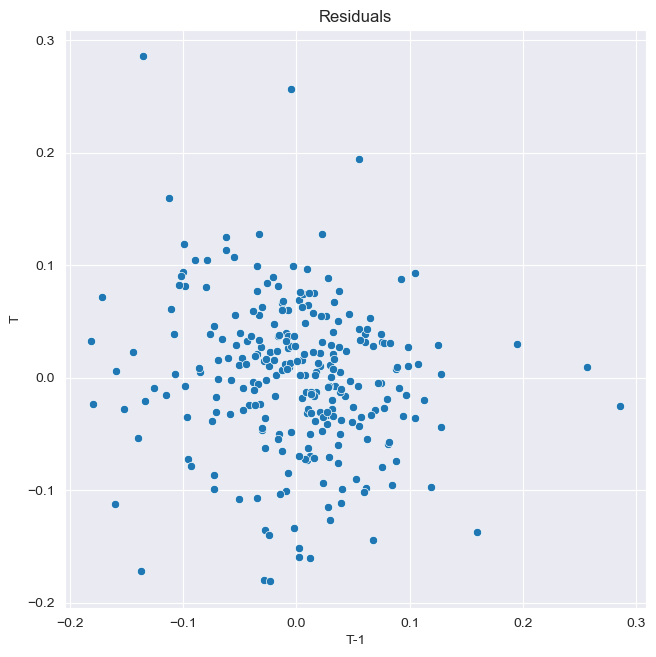

<Figure size 1000x500 with 0 Axes>

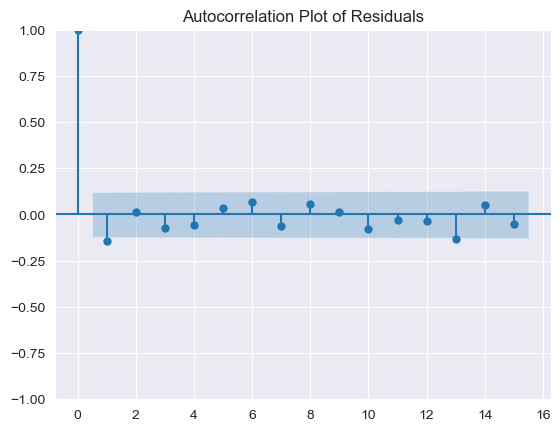

In [30]:
ols_HH.plot_residuals()

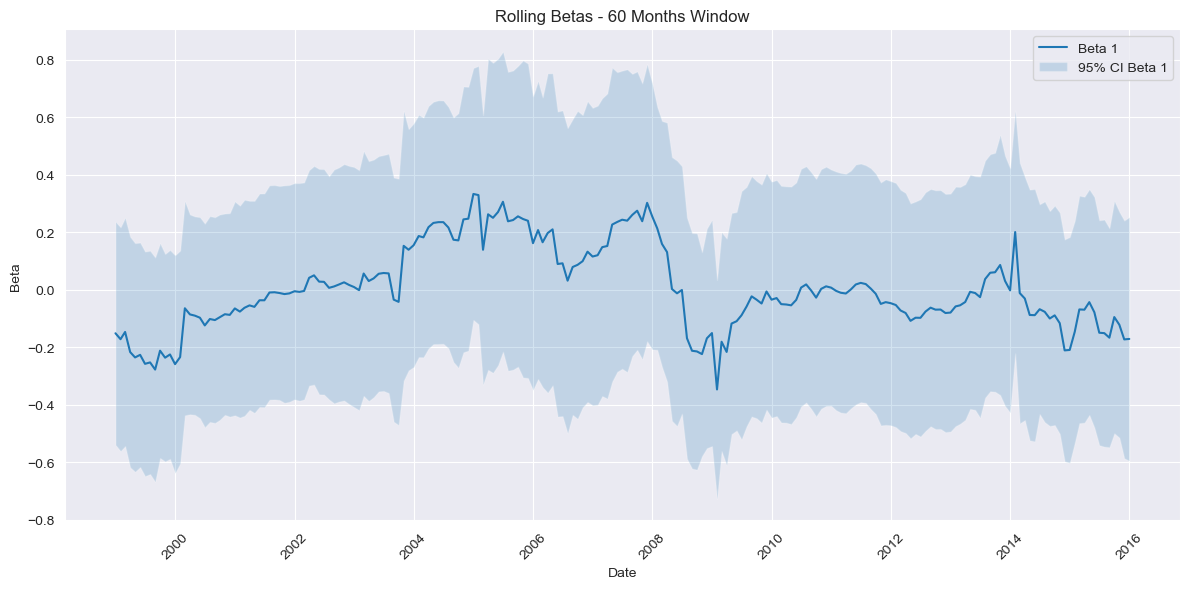

In [31]:
ols_HH.plot_rolling_betas()